# Vehicle Detection
This report contains two parts: the writeup and the source code appendix. In order to keep the writeup concise, I only implemented the core code to generate results such as images. **Please note that if you want to execute the code in the writeup, please execute the source code section first.**


## Feature Extraction
### Histogram of Oriented Gradients (HOG)
Code: ```get_hog_features()```

The Histogram of Oriented Gradients (HOG) features are used to extract information about the shape of vehicles. A total number of 9 orientations are calculated. The HOG features are calculated on each 8*8 cell. Block normalization with 2 cells per block are used to get a more robust feature set. These parameters were selected as they gave very good prediction accuracy using an SVM classifier (see the Classifier section). 

The below figures shows a visualization of HOG features for a car and non-car image.

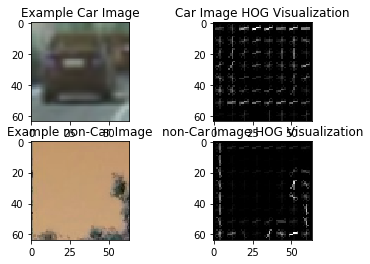

### Spatial and Color Histogram
Code: ```color_hist()``` and ```bin_spatial()```

I also included color hist and spatial features of the image as additional features to HOG. Color histogram gives a generall idea of the amount of colors that a car has. For instance, a car generally has a dominant color (e.g., white) and a small amount of other colors (black tire, red lights, etc.). Resizing images to a resonable size and use plain pixels as spatical features is also a useful feature and can compensate the fact that color hist loses spatical information. 

### Selection of Parameters
I did many experiments to find the best test accuracy. In each experiment I only change one parameter (such as color space, channel, etc.). Finally I decied to use YCrCb color space with all channels, HOG, color hist and spatial features all together. Other parameters such as HOG cell size are the same as the examples in the course material as I found these generally give very good accuracy. 

**Appending Both Spatical and Color Hist Features to HOG Gives Best Accuracy (in RGB space):**

| Spatial | Color Hist  | Test Accuracy |
|---------|-------------|---------------|
| False   | False         | 0.9848      |
|True     | False         | 0.9904      |
|False    | True         | 0.9913       |
|True     | True         | 0.9913       |

**YCrCb Color Space Gives the Best Accuracy:**

| Color Space | Test Accuracy |
|-------------|---------------|
| RGB         | 0.9848        |
| HLS         | 0.9904        |
| HSV         | 0.9913        |
| YUV         | 0.9913        |
| YCrCb       | 0.9924        |

## Classifier
Code: ```train()```

I used a linear SVM classifier as it gives best test accuracy compared to other two models that were experimented. 
** LinearSVC Gives the Best Accuracy:**

| Model | Test Accuracy |
|-------------|---------------|
| Decision Tree         | 0.9485        |
| GaussianNB         |   0.9668     |
| LiearSVC         | 0.9938        |

Before training, the data set was randomly shuffled and split into train and test data sets. The features are also normalized before feeding into the model.

In [136]:
model = LinearSVC()
# model = GaussianNB()
# model = DecisionTreeClassifier()
train(model)

63.03 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
13.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


## Sliding Window Search with Sub-Sampling

The ```find_cars``` function implements a sub-sampling of HOG features. This function only needs to extract the HOG features once and then sub-sample to get HOG features for each windows.

The sub-sampling windows are bounded to an area of interest that's specified by YStart and YEnd. The window size is controlled by a **scale** parameter. By using multiple scales, we can achieve multi-scale sliding window search.

The image below shows the performance of sliding window search on a test picture.

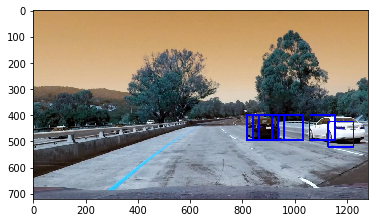

## Processing Video
The video frames are processed through a pipeline.The pipeline applies a multi-scale sliding window search on each frame and identify cars. In order to increase the robustness of the detection and reject false positives, two techniques are used:
### Heat Map
A heap map is used to keep track of number of positive detections of an area. As long as a window detects a vehicle, all pixels within that window get a heat incremented by 1. The heat map is a powerful way of telling how likely an area is a vehicle.
### Reject False Positives
A threshold can be applied to the heat map to reject a less-likely area. To make the pipeline more robust, we sum the heat maps of the current and past 4 frames and reject any area with heat smaller than a threshold(5).
### Identify Cars
After thresholding, the heat map becomes a binary map. Applying the ```scipy label()``` function can simply identify areas that contain cars.

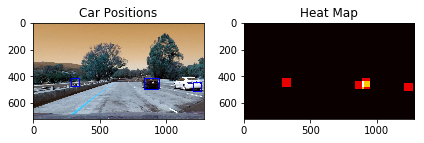

## Reflection
This project is very very interesting. It combines machine learning, feature extraction, false positive rejection techniques to develop a vehicle detection pipeline. This is one of the most rewarding project in this course! 

Here are some areas I think can be improved in the future.

** Higher Performance** I ran this pipeline on a 3.2 GHz Intel Core i5 quad-core CPU and it processes around 1.5 frames/s, which is too slow for a real-time detection. We can explore different parameters when extrating features and use less features as long as the classifier gives good enough accuracy. A simplified model can siginificantly reduce prediction time. 

**Robustness of the False Positive Rejection**: So far the false positive rejection is proven to work on the test video, however, it's doubtful whether it works robustly under different road/weather conditions. More videos under different conditions need to be exploered to tune the thresholding logic.

**Detecting Abnormal Vehicles**: So far the pipeline works well on detecting regular vehicles, however, it's not proven to be able to detect abnormal vehicles such as big buses, street cars tanks, etc. To make it work for all vehicle types, first we need to train the classifier with more vehicle types. Also, we need to find a better sliding window method to detect these vehicles as they may appear in larger size.

## Appendix: Source Code

In [123]:
# All required packages
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import math
import glob
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


In [135]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Calculate HOG features and visualization
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    '''
    Function to get color histogram of the input iage
    '''
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    '''
    function to compute binned color features  
    '''
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
       Function to extract features from a list of images
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat=True, hist_feat=True):
    '''
    Use HOG sub-sampling to slide windows to search cars in an input image
    '''
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            combined_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            # Scale features and make a prediction
            test_features = X_scaler.transform(combined_features)    
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list

## Explore HOG features

In [ ]:
car_image_files = glob.glob('./data/vehicles/*/*.png')
non_car_image_files = glob.glob('./data/non-vehicles/*/*.png')
# Read in the image
car_image = cv2.imread(car_image_files[0])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2YCrCb)
non_car_image = cv2.imread(non_car_image_files[0])
non_car_gray = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(car_gray[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, non_car_hog_image = get_hog_features(non_car_gray[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(221)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car Image HOG Visualization')
plt.subplot(223)
plt.imshow(non_car_image, cmap='gray')
plt.title('Example non-Car Image')
plt.subplot(224)
plt.imshow(non_car_hog_image, cmap='gray')
plt.title('non-Car Image HOG Visualization')

## Train the data

In [128]:
def train(model):
    cars = glob.glob('./data/vehicles/*/*.png')
    notcars = glob.glob('./data/non-vehicles/*/*.png')

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    # Check the training time for the SVC
    t=time.time()
    model.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train Model...')
    # Check the score of the SVC
    print('Test Accuracy of Model = ', round(model.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    


## Sliding Window Search

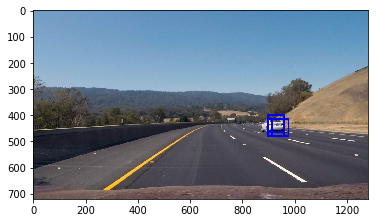

In [105]:
image = cv2.imread('./test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ystart = 400
ystop = 600
scale = 1
file = ['./test_images/image0053.png']
file = ['./test_images/test00.jpg']

out_img, box_list = find_cars(image, ystart, ystop, scale, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

## Heat Map and False Positive Rejection

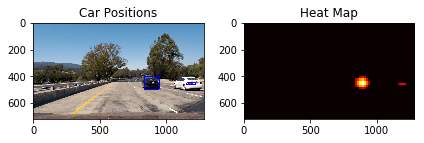

In [104]:
# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Vecicle Detector Pipeline

In [160]:
class VehicleDetector():
    
    def __init__(self,
                 ystart, 
                 ystop,
                 scale_list,
                 model, 
                 X_scaler, 
                 orient, 
                 pix_per_cell, 
                 cell_per_block, 
                 spatial_size, 
                 hist_bins,
                 memory_size,
                 threshold):
        '''
        :param model: Pre-trained model to classify cars vs. non-cars.
        :param X_scaler: Scaler used to normalize image data when training the model.
        :param ystart: Upper bound of Area of Interest to search.
        :param ystop: Lower bound of Area of Interest to search.
        :param scale_list: List of scales used to search cars
        :param orient: Number of gradient bins for HOG features
        :param pix_per_cell:HOG feature param
        :param cell_per_block: HOG feature param
        :param spatial_size: Size transform tuple for the spatial features
        :param hist_bins: Number of histogram bins for color_hist
        :param memory_size: Number of frames in the past to remove false postives
        :param threshold Reject if heat<threshold
        '''
        self.model = model
        self.X_scaler = X_scaler
        self.ystart = ystart
        self.ystop = ystop
        self.scale_list = scale_list
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.memory_size = memory_size
        self.threshold = threshold
        self.buffer = [None]*memory_size
        # the count of current frame
        self.frame_count = -1
    
    def detect(self, image):  
        '''
        Detect vehicles from an image and draw a box on the vehicle
        '''
        self.frame_count += 1
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        for scale in scale_list:
            tmp, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            # Add heat to each box in box list
            heat = add_heat(heat,box_list)
        self.buffer[self.frame_count%self.memory_size] = heat
        return self.reject_false_positive(image)
           
    def reject_false_positive(self, image):
        '''
        Apply threshold on the aggregate heat map of several frames
        Filter out areas that has heat<threshold
        '''
        if self.frame_count >= self.memory_size:
            sum_heat = np.sum(self.buffer, axis=0)
        else:
            sum_heat = np.sum(self.buffer[:self.frame_count+1], axis=0)
        # Apply threshold to help remove false positives
        sum_heat = apply_threshold(sum_heat,self.threshold)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(sum_heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        return draw_img
    
ystart = 400
ystop = 650
scale_list = [1,1.5]# a scale corresponds to a sliding window side
memory_size = 5 #using (memory_size-1) historical frames to reject false positives
threshold = 5
detector = VehicleDetector(ystart, ystop, scale_list, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, memory_size,threshold)

def pipeline(image):
    '''
    pipeline to process each video frame
    '''
    result = detector.detect(image)
    return result

## Process Video

In [162]:
output = 'project_video_output_5-5-2.mp4'
clip = VideoFileClip("project_video_lane.mp4")
new_clip = clip.fl_image(pipeline)
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_5-5-2.mp4
[MoviePy] Writing video project_video_output_5-5-2.mp4


100%|█████████▉| 1260/1261 [20:27<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_5-5-2.mp4 

CPU times: user 19min 26s, sys: 49 s, total: 20min 15s
Wall time: 20min 28s
